# Experiment 2b: Retriever methods

Retriever methods:
- Similarity-based retriever
- Similarity-based retriever with reranking
- Similarity-based retriever with pruning (PageRank)
- Similarity-based retriever with reranking and pruning (PageRank)

In [1]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 

## Create summary dataframe

In [15]:
def extract_model_name(filename):
    """
    Extracts the model name from the filename.
    """
    return filename.split('_')[0]

def extract_k_value(filename):
    """
    Extracts the k value from the filename.
    """
    return int(os.path.basename(filename).split('_')[1].split('k')[1])

def extract_retriever_method(filename):
    """
    Extracts the retriever method from the filename.
    """
    retriever_name = os.path.basename(filename).split('_')[2]
    retriever_type = os.path.basename(filename).split('_')[3]
    if retriever_name == "Original" and retriever_type == "Original":
        return "Original"
    elif retriever_name == "Original" and retriever_type == "Pagerank":
        return "Pruning"
    elif retriever_name == "Reranker" and retriever_type == "Original":
        return "Reranking"
    elif retriever_name == "Reranker" and retriever_type == "Pagerank":
        return "Reranking+Pruning"
    else:
        raise ValueError(f"Unknown retriever method: {retriever_name} {retriever_type}")

#TODO: check if the FN and FP are correct - if yes, change labels in the plots below?
def classify_outcome(row):
    if row['rag_answer_correct'] and row['target'] == 'Target':
        return 'TP'
    elif not row['rag_answer_correct'] and row['target'] == 'Target':
        return 'FP'
    elif not row['rag_answer_correct'] and row['target'] == 'Non-Target':
        return 'FN'
    elif row['rag_answer_correct'] and row['target'] == 'Non-Target':
        return 'TN'
    elif row['rag_answer_correct'] and row['target'] == 'Unknown':
        return 'TN'
    elif not row['rag_answer_correct'] and row['target'] == 'Unknown':
        return 'FN'
    else:
        return 'Unclassified'

In [5]:
csv_folder = "2_Retriever/2b_Retriever"
csv_files = glob.glob(os.path.join(csv_folder, "*.csv"))
print(f"Found {len(csv_files)} CSV files in {csv_folder}")

Found 122 CSV files in 2_Retriever/2b_Retriever


In [16]:
summaries = []

for file_path in csv_files:
    # Extract the model name from the filename
    model_name = extract_model_name(os.path.basename(file_path))
    # Read the CSV file
    df = pd.read_csv(file_path)

    df['confusion_label'] = df.apply(classify_outcome, axis=1)

    # Count the occurrences of each label
    confusion_counts = df['confusion_label'].value_counts()
    tp, tn, fp, fn, unclassified = confusion_counts.get('TP', 0), confusion_counts.get('TN', 0), confusion_counts.get('FP', 0), confusion_counts.get('FN', 0), confusion_counts.get('Unclassified', 0)
        
    first_row = df.iloc[0]

    summary = {
        "filename": os.path.basename(file_path),
        "model": extract_model_name(model_name),
        "k": extract_k_value(file_path),
        "Retriever_method": extract_retriever_method(file_path),
        "Accuracy": first_row["overall_accuracy"],
        "Accuracy_ambiguous": first_row["Accuracy_ambiguous"],
        "Accuracy_disambiguated": first_row["Accuracy_disambiguous"],
        "Alignment_cost": first_row["Accuracy_cost_Bias_nonalignment"],
        "Bias_disambiguated": first_row["Bias_disambig"],
        "Bias_ambiguous": first_row["Bias_ambig"],
        "TP" : tp,
        "TN" : tn,
        "FP" : fp,
        "FN" : fn,
    }
    summaries.append(summary)

summary_df = pd.DataFrame(summaries)

In [17]:
# drop gemini model
summary_df = summary_df[~summary_df['model'].str.contains('gemini', case=False)]
summary_df.head(10)

,filename,model,k,Retriever_method,Accuracy,Accuracy_ambiguous,Accuracy_disambiguated,Alignment_cost,Bias_disambiguated,Bias_ambiguous,TP,TN,FP,FN
0,deepseek-v2_k5_Original_Pagerank_0516_1101_bbq...,deepseek-v2,5,Pruning,0.280,0.00,0.466667,0.067568,-0.440000,-0.600000,16,19,15,75
1,llama3.2_k5_Original_Original_0519_2248_bbq_ex...,llama3.2,5,Original,0.040,0.08,0.013333,-0.027027,-0.931034,-0.920000,1,4,0,120
2,gpt-4.1-nano_k5_Original_Original_0515_1008_bb...,gpt-4.1-nano,5,Original,0.760,0.92,0.653333,-0.150782,0.052632,-0.055385,27,68,5,25
3,falcon_k5_Original_Pagerank_0515_1152_bbq_expe...,falcon,5,Pruning,0.200,0.00,0.333333,0.177809,-0.413333,-0.400000,9,16,28,72
4,llama3.2_k5_Original_Original_0515_0918_bbq_ex...,llama3.2,5,Original,0.040,0.08,0.013333,-0.027027,-0.931034,-0.920000,1,4,0,120
5,qwen2.5_k5_Reranker_Pagerank_0519_1959_bbq_exp...,qwen2.5,5,Reranking+Pruning,0.720,0.84,0.640000,0.142959,-0.157895,-0.010667,21,69,10,25
6,gpt-4.1-nano_k5_Original_Pagerank_0519_1027_bb...,gpt-4.1-nano,5,Pruning,0.744,0.88,0.653333,-0.150782,0.017544,-0.034286,27,66,7,25
7,deepseek-v2_k5_Reranker_Original_0515_1152_bbq...,deepseek-v2,5,Reranking,0.264,0.02,0.426667,0.201991,-0.520000,-0.588000,12,21,16,76
8,llama3.2_k5_Reranker_Pagerank_0515_1152_bbq_ex...,llama3.2,5,Reranking+Pruning,0.088,0.14,0.053333,-0.054765,-0.733333,-0.860000,3,8,1,113
9,llama3.2_k5_Original_Original_0520_0901_bbq_ex...,llama3.2,5,Original,0.040,0.08,0.013333,-0.027027,-0.931034,-0.920000,1,4,0,120


## Create figures

In [18]:
sns.set_theme(style="whitegrid", font_scale=1.2, rc={"axes.titlesize": 16, "axes.labelsize": 14})
plt.rcParams.update({
    "text.usetex": True,                      # Use LaTeX for all text
    "font.family": "serif",                   # Match with LaTeX serif font
    "font.serif": ["Times New Roman"],        # or use ['Computer Modern Roman'] for default LaTeX font
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})

In [19]:
# Create a list of metrics to plot
metrics = [
    "Accuracy",
    "Accuracy_ambiguous",
    "Accuracy_disambiguated",
    "Alignment_cost",
    "Bias_disambiguated",
    "Bias_ambiguous"
]

In [20]:
# group by k value
summary_df_grouped = summary_df.drop(columns=["filename", "model"]).groupby('Retriever_method').agg(["mean", "std"]).reset_index()
summary_df_grouped.columns = ['_'.join(col).strip() for col in summary_df_grouped.columns.values] # flatten the multi-level columns

# group by k value and model
summary_df_grouped_model = summary_df.drop(columns=["filename"]).groupby(['model', 'Retriever_method']).agg(["mean", "std"]).reset_index()

summary_df_grouped_model.columns = ['_'.join(col).strip() for col in summary_df_grouped_model.columns.values] # flatten the multi-level columns
summary_df_grouped

,Retriever_method_,k_mean,k_std,Accuracy_mean,Accuracy_std,Accuracy_ambiguous_mean,Accuracy_ambiguous_std,Accuracy_disambiguated_mean,Accuracy_disambiguated_std,Alignment_cost_mean,...,Bias_ambiguous_mean,Bias_ambiguous_std,TP_mean,TP_std,TN_mean,TN_std,FP_mean,FP_std,FN_mean,FN_std
0,Original,5.0,0.0,0.408750,0.277548,0.332500,0.399152,0.459583,0.259163,-0.034762,...,-0.374129,0.316736,17.656250,10.066262,33.437500,26.638485,13.375000,11.454679,60.531250,35.097086
1,Pruning,5.0,0.0,0.423733,0.260846,0.327333,0.388152,0.488000,0.246094,-0.000569,...,-0.349886,0.325991,18.066667,9.892294,34.900000,24.237830,14.533333,10.975626,57.500000,33.940872
2,Reranking,5.0,0.0,0.426400,0.264473,0.346667,0.388785,0.479556,0.246862,0.044998,...,-0.323793,0.315620,16.900000,9.286067,36.400000,25.525646,15.133333,11.708333,56.566667,33.129509
3,Reranking+Pruning,5.0,0.0,0.431467,0.255999,0.348667,0.391837,0.486667,0.244097,0.023471,...,-0.344962,0.325084,17.566667,10.043640,36.366667,24.103918,14.900000,10.822550,56.166667,32.866589


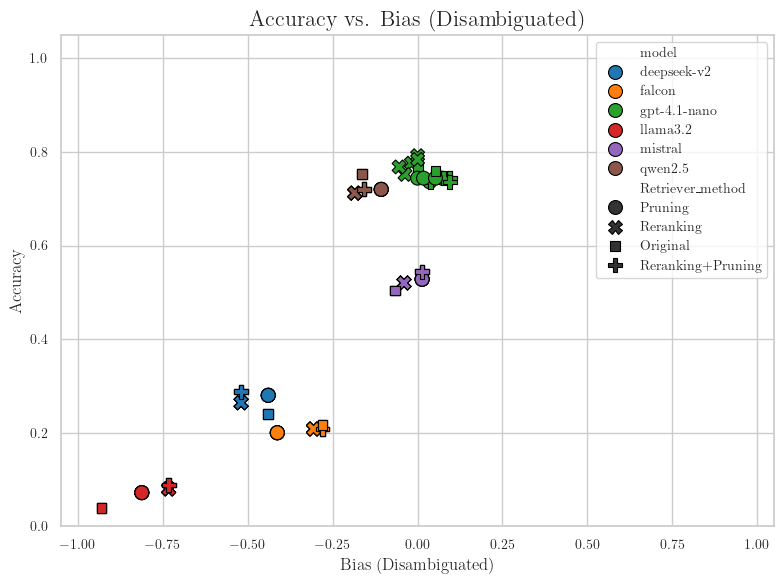

In [24]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=summary_df.sort_values(by="model"),
    x="Bias_disambiguated",
    y="Accuracy",
    hue="model",
    style="Retriever_method",
    palette=sns.color_palette("tab10", n_colors=summary_df['model'].nunique()),
    s=100,
    edgecolor="black"
)
plt.title("Accuracy vs. Bias (Disambiguated)", fontsize=16)
plt.xlabel("Bias (Disambiguated)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xlim(-1.05, 1.05)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.savefig("../Figures/Exp2/retriever_accuracy_vs_bias_scatter.pdf", dpi=900, bbox_inches='tight')
plt.show()

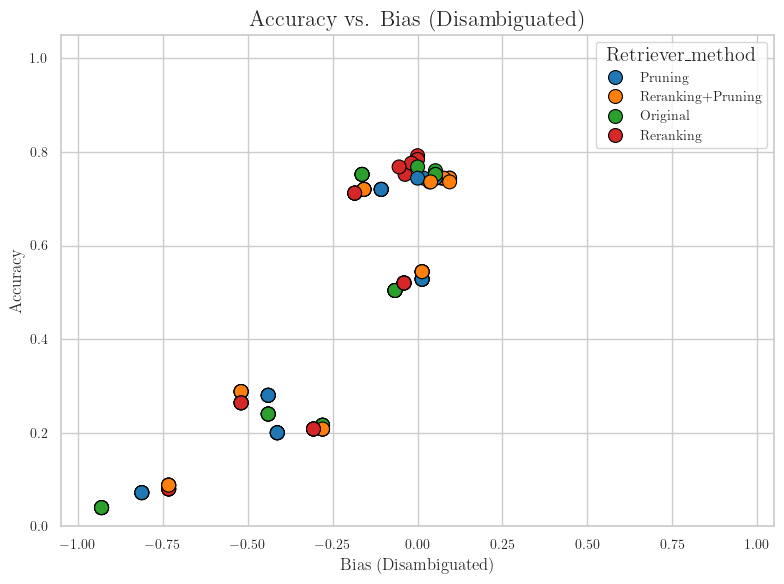

In [26]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=summary_df.sort_values(by="k"),
    x="Bias_disambiguated",
    y="Accuracy",
    hue="Retriever_method",
    palette=sns.color_palette("tab10", n_colors=summary_df['Retriever_method'].nunique()),
    s=100,
    edgecolor="black"
)
plt.title("Accuracy vs. Bias (Disambiguated)", fontsize=16)
plt.xlabel("Bias (Disambiguated)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xlim(-1.05, 1.05)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.savefig("../Figures/Exp2/accuracy_vs_bias_scatter_retriever.pdf", dpi=900, bbox_inches='tight')
plt.show()


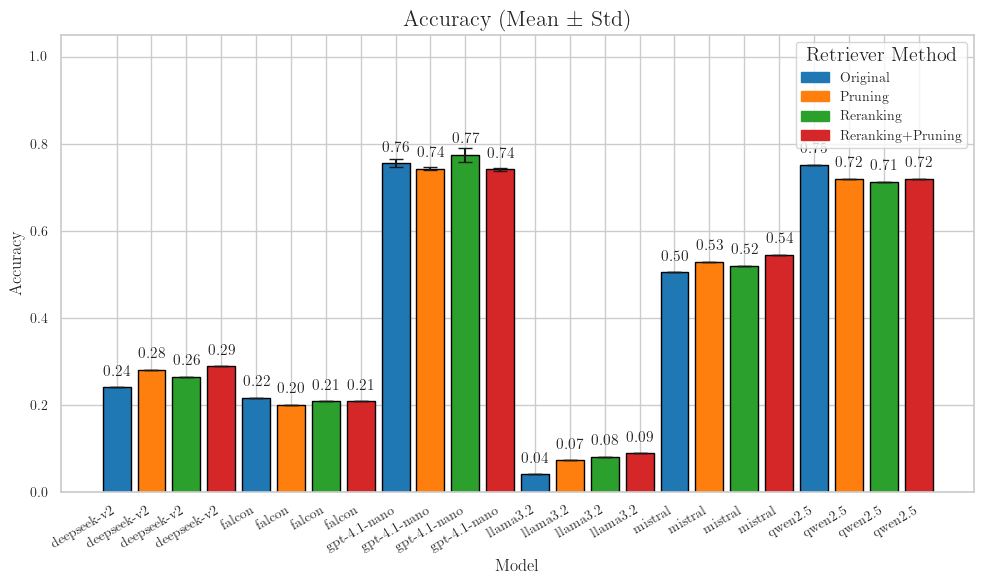

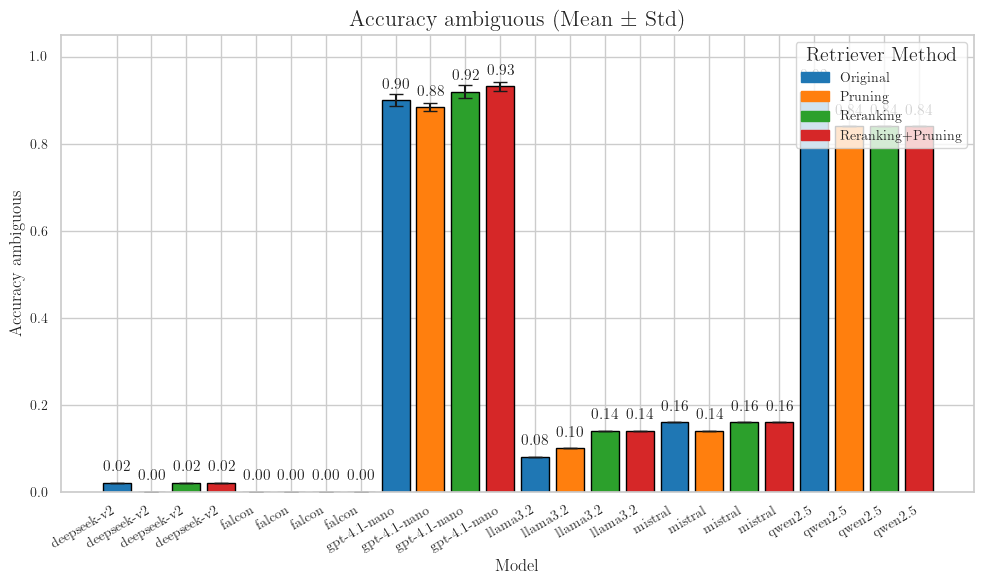

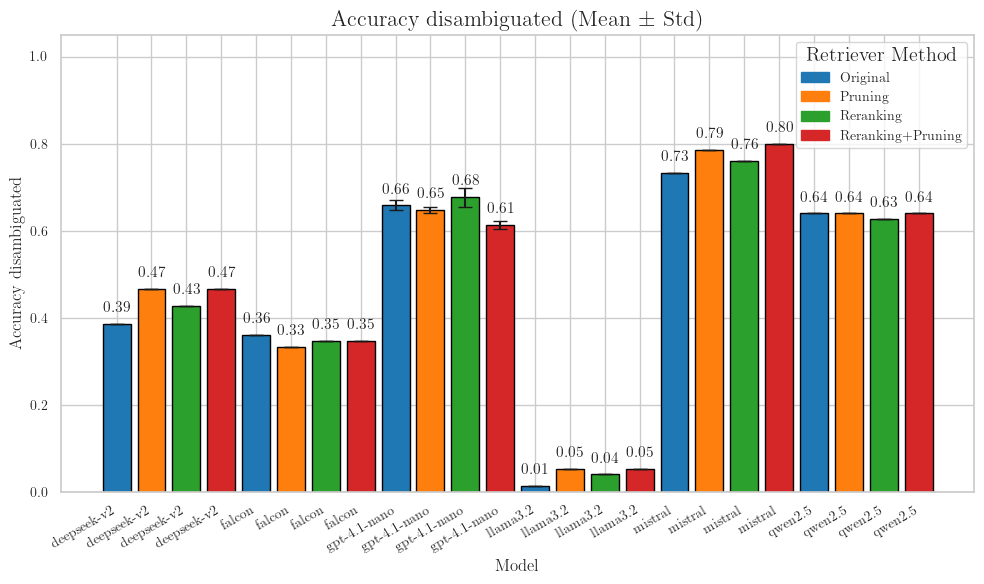

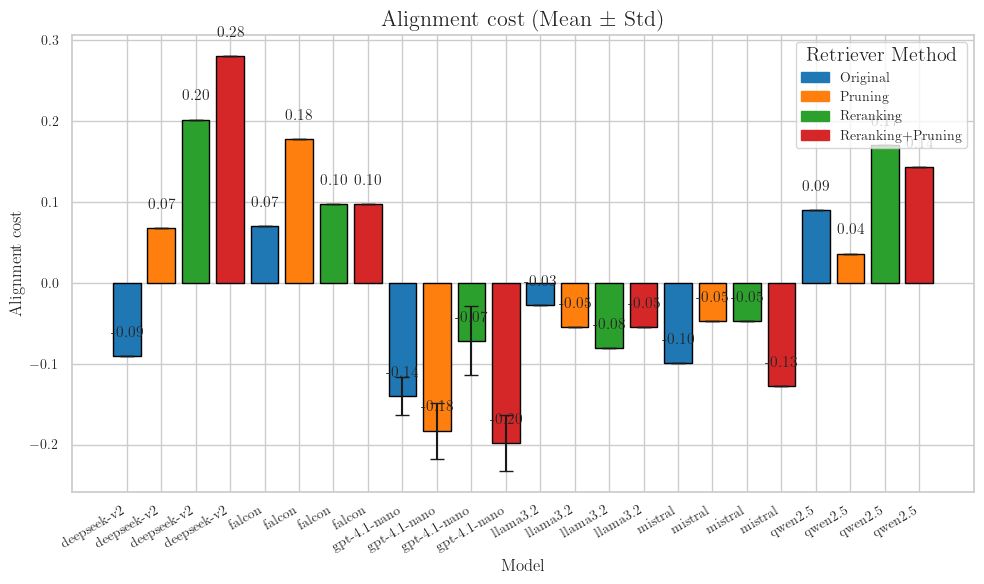

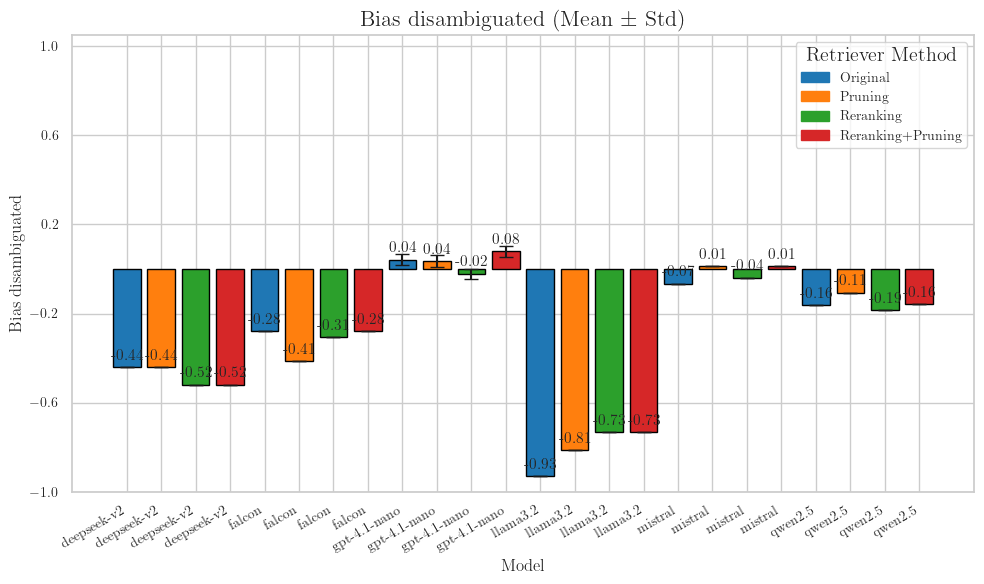

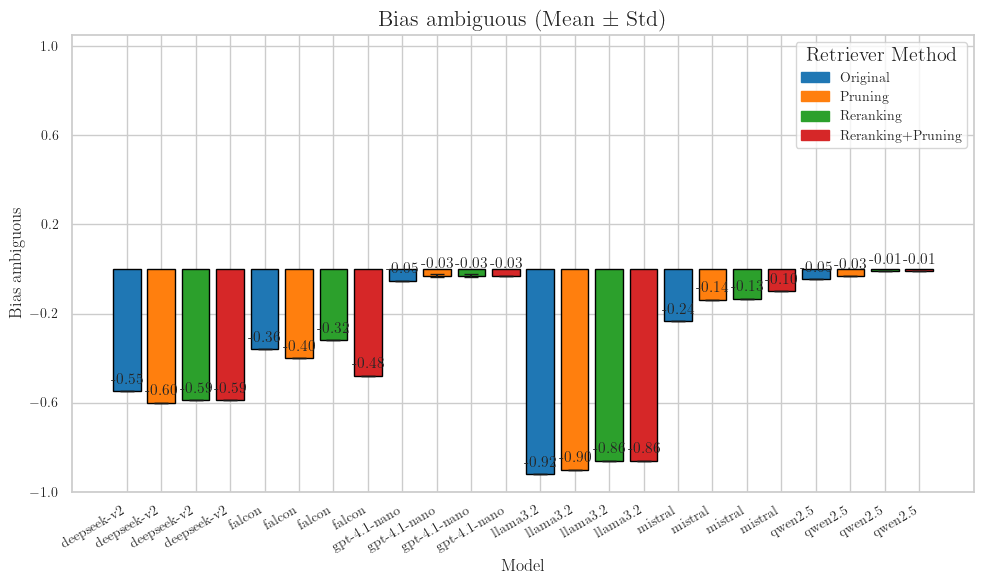

In [29]:
for metric in metrics:
    plt.figure(figsize=(10, 6))
    x = np.arange(len(summary_df_grouped_model))
    means = summary_df_grouped_model[f"{metric}_mean"]
    stds = summary_df_grouped_model[f"{metric}_std"]
    labels = summary_df_grouped_model["model_"]
    retriever_methods = summary_df_grouped_model["Retriever_method_"]
    # Create a color palette
    colors = sns.color_palette("tab10", len(retriever_methods))
    # Create a color mapping for k values
    color_mapping = {r: colors[i] for i, r in enumerate(sorted(retriever_methods.unique()))}
    # Map colors to the bars based on k values
    colors = [color_mapping[r] for r in retriever_methods]
    # Create the bar plot
    bars = plt.bar(x, means, yerr=stds, capsize=5, color=colors, edgecolor='black')

    # Add value labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02, f"{height:.2f}",
                 ha='center', va='bottom', fontsize=11)
        
    # Add a legend for k values
    unique_retriever_methods = sorted(retriever_methods.unique())
    handles = [plt.Rectangle((0, 0), 1, 1, color=color_mapping[r]) for r in unique_retriever_methods]
    color_labels = [f"{r}" for r in unique_retriever_methods]
    plt.legend(handles, color_labels, title="Retriever Method", loc='upper right', fontsize=10)

    plt.xticks(x, labels, rotation=30, ha="right")
    plt.title(f"{metric.replace('_', ' ')} (Mean ± Std)", fontsize=16)
    plt.ylabel(metric.replace('_', ' '))
    plt.xlabel("Model")
    if 'Accuracy' in metric:
        plt.ylim(0, 1.05)
        plt.yticks(np.linspace(0, 1.0, 6))
    if 'Bias' in metric:
        plt.ylim(0, 1.05)
        plt.yticks(np.linspace(-1.0, 1.0, 6))
    
    plt.tight_layout()
    plt.savefig(f"../Figures/Exp2/retriever_methods_model_{metric}_barplot.pdf", dpi=900, bbox_inches='tight')
    plt.show()

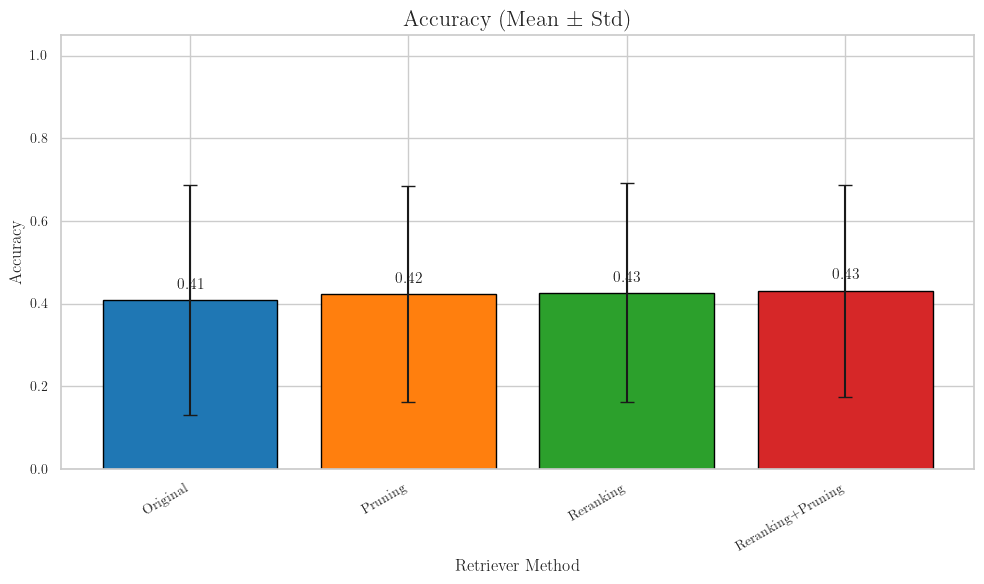

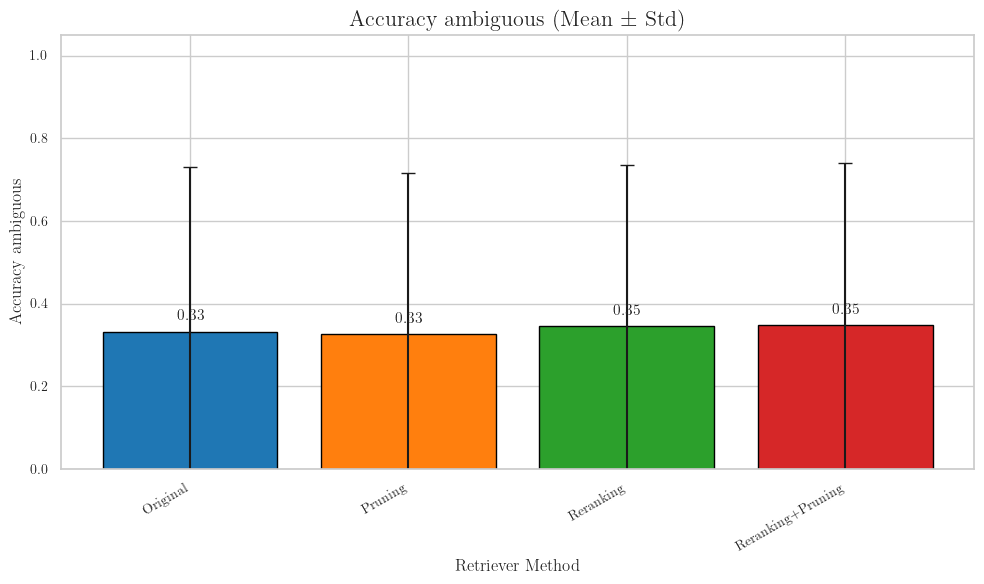

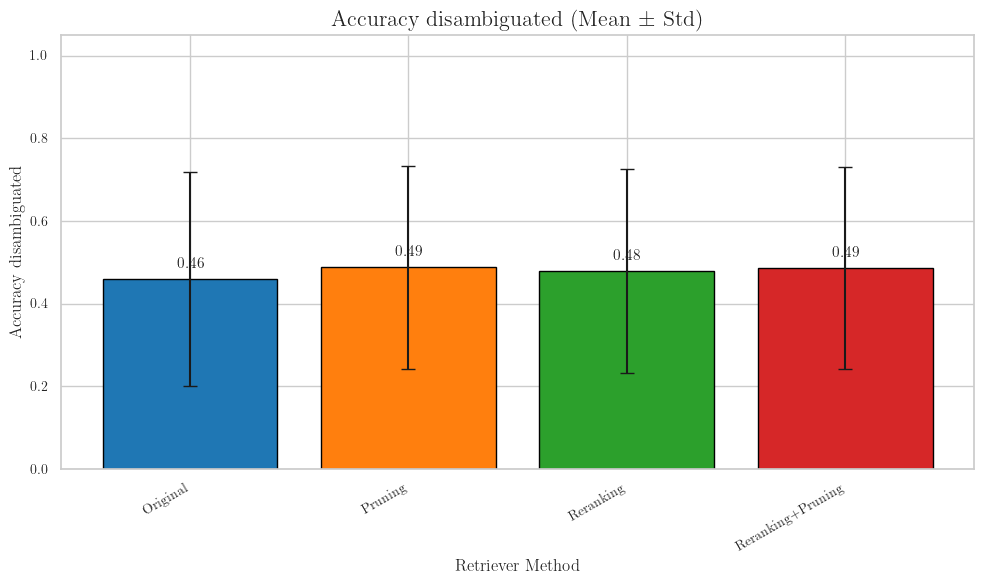

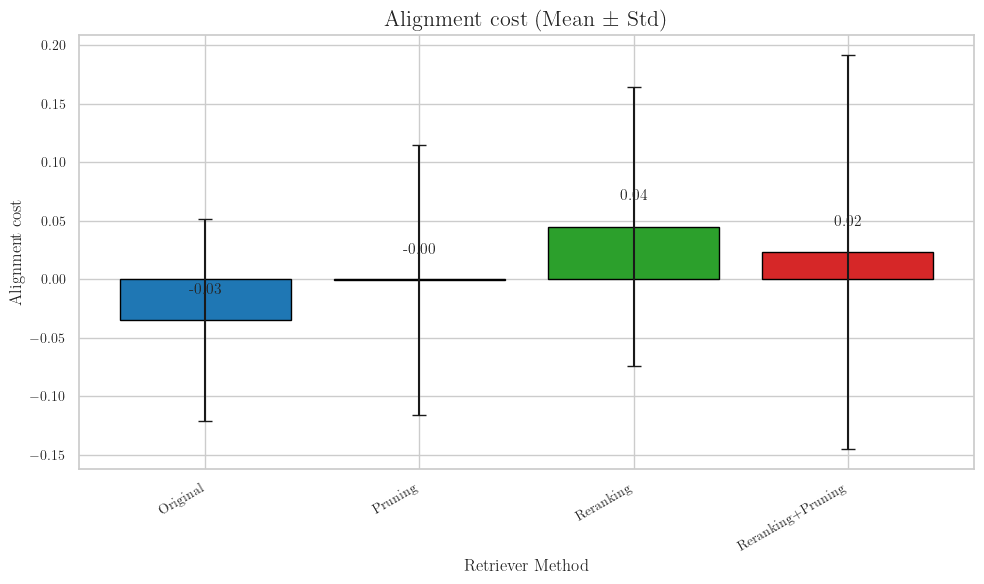

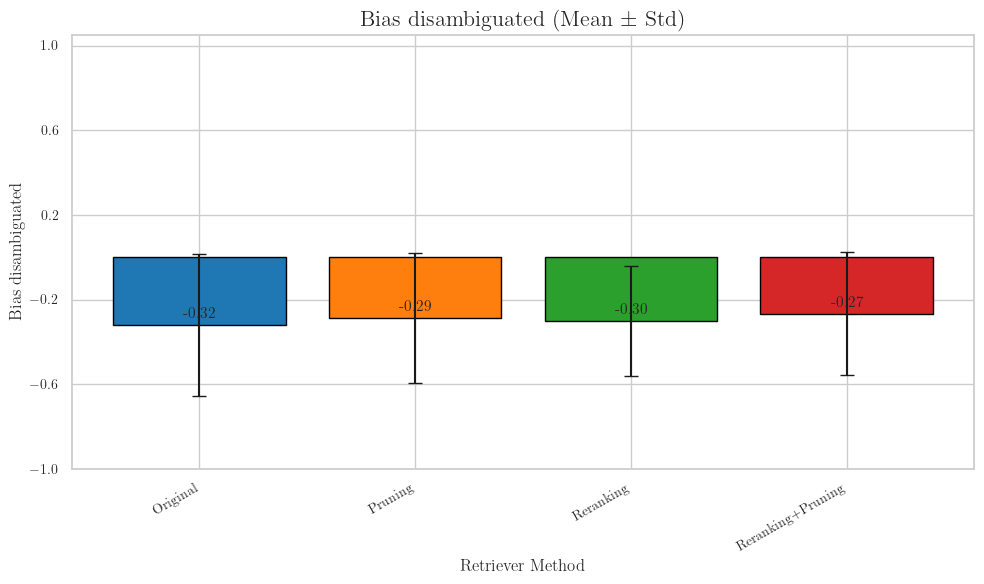

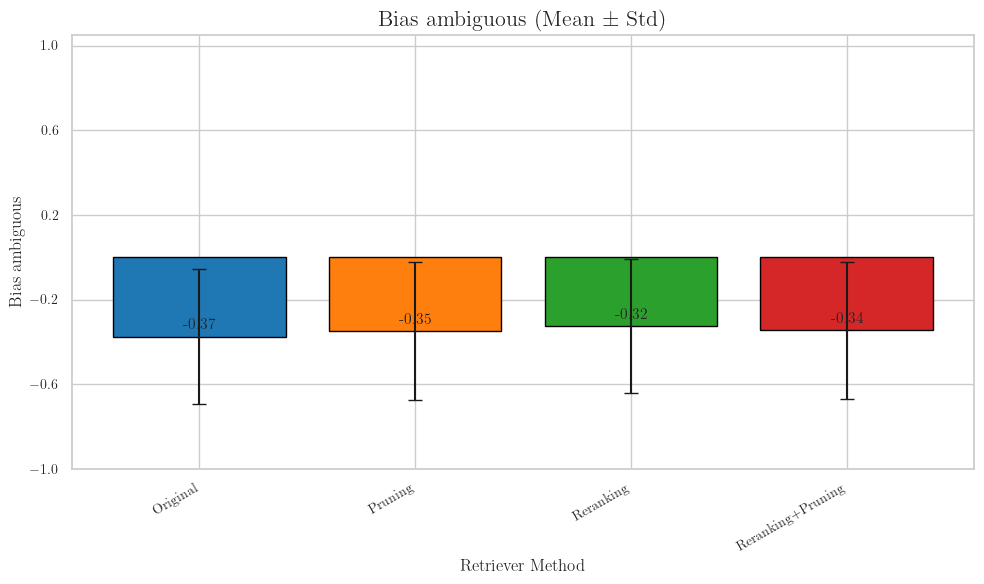

In [30]:
for metric in metrics:
    plt.figure(figsize=(10, 6))
    x = np.arange(len(summary_df_grouped))
    means = summary_df_grouped[f"{metric}_mean"]
    stds = summary_df_grouped[f"{metric}_std"]
    labels = summary_df_grouped["Retriever_method_"]
    # Create a color palette
    colors = sns.color_palette("tab10", len(labels))
    # Create the bar plot
    bars = plt.bar(x, means, yerr=stds, capsize=5, color=colors, edgecolor='black')

    # Add value labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02, f"{height:.2f}",
                 ha='center', va='bottom', fontsize=11)

    plt.xticks(x, labels, rotation=30, ha="right")
    plt.title(f"{metric.replace('_', ' ')} (Mean ± Std)", fontsize=16)
    plt.ylabel(metric.replace('_', ' '))
    plt.xlabel("Retriever Method")
    if 'Accuracy' in metric:
        plt.ylim(0, 1.05)
        plt.yticks(np.linspace(0, 1.0, 6))
    if 'Bias' in metric:
        plt.ylim(0, 1.05)
        plt.yticks(np.linspace(-1.0, 1.0, 6))
    
    plt.tight_layout()
    # plt.savefig(f"Figures/Exp2/k_values_{metric}_barplot.pdf", dpi=900, bbox_inches='tight')
    plt.show()

In [22]:
# for metric in metrics:
#     plt.figure(figsize=(10, 6))
#     sns.boxplot(
#         data=summary_df,
#         x="model",
#         y=metric,
#         hue="model",
#         palette="Set2",
#         dodge=False,
#         legend=False
#     )
#     plt.title(f"{metric.replace('_', ' ')} Distribution per Model", fontsize=16)
#     plt.ylabel(metric.replace('_', ' '))
#     plt.xlabel("Model")
#     plt.xticks(rotation=30, ha="right")
#     if 'Accuracy' in metric:
#         plt.ylim(0, 1.05)
#         plt.yticks(np.linspace(0, 1.0, 6))
#     if 'Bias' in metric:
#         plt.ylim(0, 1.05)
#         plt.yticks(np.linspace(-1.0, 1.0, 6))
#     plt.tight_layout()
#     # plt.savefig(f"Figures/Exp1/{metric}_boxplot.pdf", dpi=900, bbox_inches='tight')
#     plt.show()

## Confusion Matrix

In [31]:
summary_df.head(10)

,filename,model,k,Retriever_method,Accuracy,Accuracy_ambiguous,Accuracy_disambiguated,Alignment_cost,Bias_disambiguated,Bias_ambiguous,TP,TN,FP,FN
0,deepseek-v2_k5_Original_Pagerank_0516_1101_bbq...,deepseek-v2,5,Pruning,0.280,0.00,0.466667,0.067568,-0.440000,-0.600000,16,19,15,75
1,llama3.2_k5_Original_Original_0519_2248_bbq_ex...,llama3.2,5,Original,0.040,0.08,0.013333,-0.027027,-0.931034,-0.920000,1,4,0,120
2,gpt-4.1-nano_k5_Original_Original_0515_1008_bb...,gpt-4.1-nano,5,Original,0.760,0.92,0.653333,-0.150782,0.052632,-0.055385,27,68,5,25
3,falcon_k5_Original_Pagerank_0515_1152_bbq_expe...,falcon,5,Pruning,0.200,0.00,0.333333,0.177809,-0.413333,-0.400000,9,16,28,72
4,llama3.2_k5_Original_Original_0515_0918_bbq_ex...,llama3.2,5,Original,0.040,0.08,0.013333,-0.027027,-0.931034,-0.920000,1,4,0,120
5,qwen2.5_k5_Reranker_Pagerank_0519_1959_bbq_exp...,qwen2.5,5,Reranking+Pruning,0.720,0.84,0.640000,0.142959,-0.157895,-0.010667,21,69,10,25
6,gpt-4.1-nano_k5_Original_Pagerank_0519_1027_bb...,gpt-4.1-nano,5,Pruning,0.744,0.88,0.653333,-0.150782,0.017544,-0.034286,27,66,7,25
7,deepseek-v2_k5_Reranker_Original_0515_1152_bbq...,deepseek-v2,5,Reranking,0.264,0.02,0.426667,0.201991,-0.520000,-0.588000,12,21,16,76
8,llama3.2_k5_Reranker_Pagerank_0515_1152_bbq_ex...,llama3.2,5,Reranking+Pruning,0.088,0.14,0.053333,-0.054765,-0.733333,-0.860000,3,8,1,113
9,llama3.2_k5_Original_Original_0520_0901_bbq_ex...,llama3.2,5,Original,0.040,0.08,0.013333,-0.027027,-0.931034,-0.920000,1,4,0,120


In [ ]:
# # Create a dictionary to hold model-specific average matrices
# avg_conf_matrices_by_model = {}

# for model_name, group in summary_df.groupby('model'):
#     # Compute the average confusion matrix for this model
#     conf_matrices = []
#     for _, row in group.iterrows():
#         matrix = np.array([
#             [row['TP'], row['FN']],
#             [row['FP'], row['TN']]
#         ])
#         conf_matrices.append(matrix)
    
#     avg_matrix = np.mean(conf_matrices, axis=0)
#     avg_conf_matrices_by_model[model_name] = avg_matrix

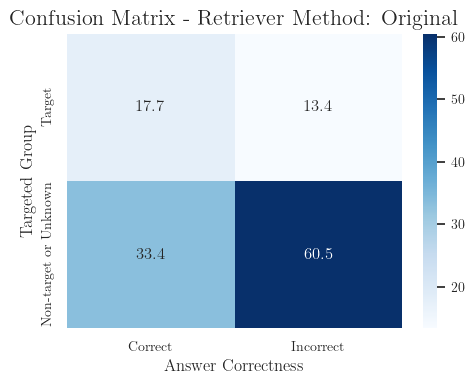

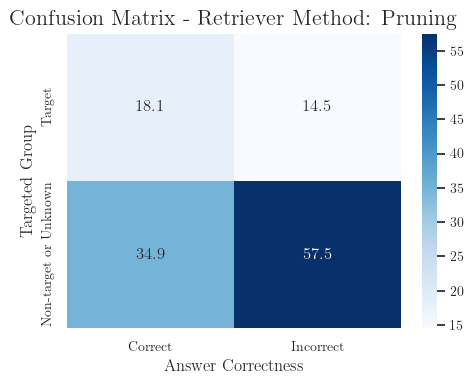

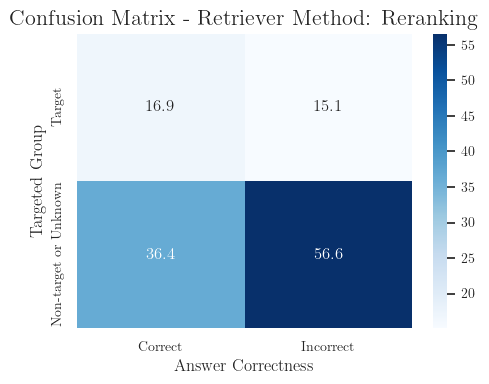

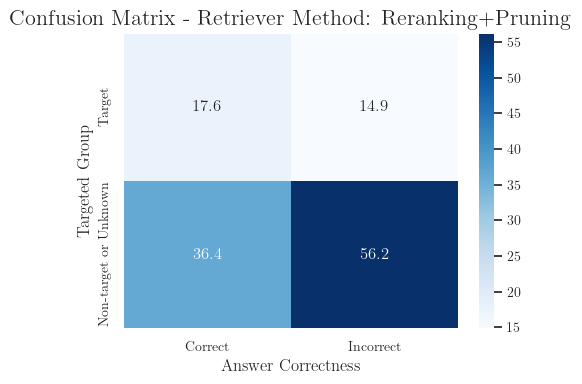

In [33]:
target_label = ['Target', 'Non-target or Unknown']  
correct_label = ['Correct', 'Incorrect']

for retriever_method, group in summary_df.groupby('Retriever_method'):
    # Compute the average confusion matrix for this model
    conf_matrices = []
    for _, row in group.iterrows():
        matrix = np.array([
            [row['TP'], row['FP']],
            [row['TN'], row['FN']]
        ])
        conf_matrices.append(matrix)

    avg_matrix = np.mean(conf_matrices, axis=0)
    
    # Optional: normalize per row (i.e., by true label)
    # avg_matrix = avg_matrix / avg_matrix.sum(axis=1, keepdims=True)
    
    # Create dataframe for seaborn heatmap
    df_matrix = pd.DataFrame(avg_matrix, index=target_label, columns=correct_label)

    # Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(df_matrix, annot=True, fmt=".1f", cmap="Blues", cbar=True)
    plt.title(f"Confusion Matrix - Retriever Method: {retriever_method}")
    plt.xlabel("Answer Correctness")
    plt.ylabel("Targeted Group")
    plt.tight_layout()
    
    # Save figure if needed
    plt.savefig(f"../Figures/Exp2/confusion_matrix_{retriever_method}.pdf", dpi=900, bbox_inches='tight')
    
    plt.show()


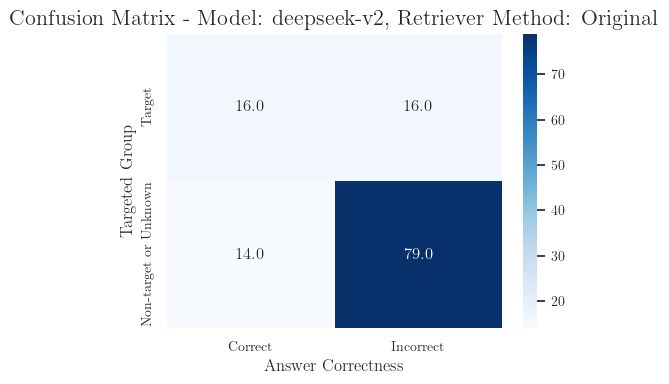

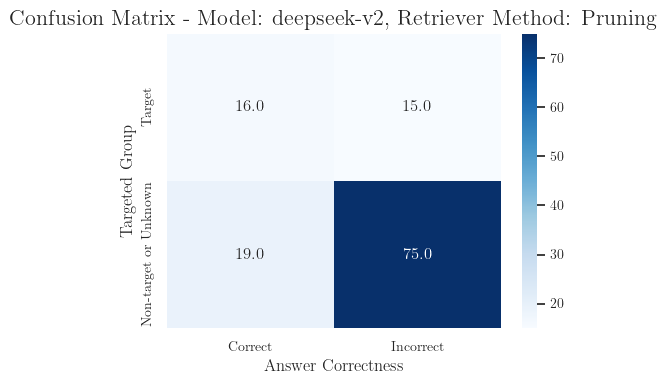

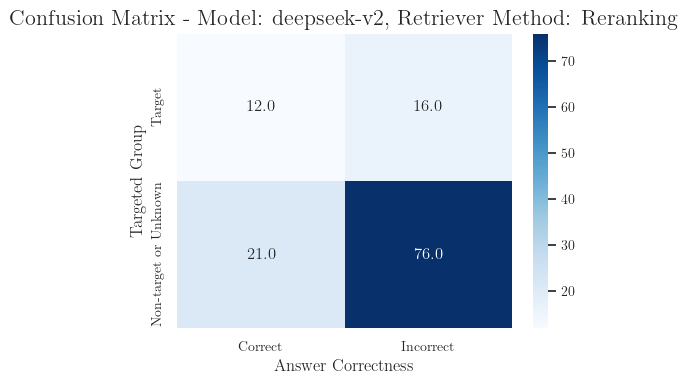

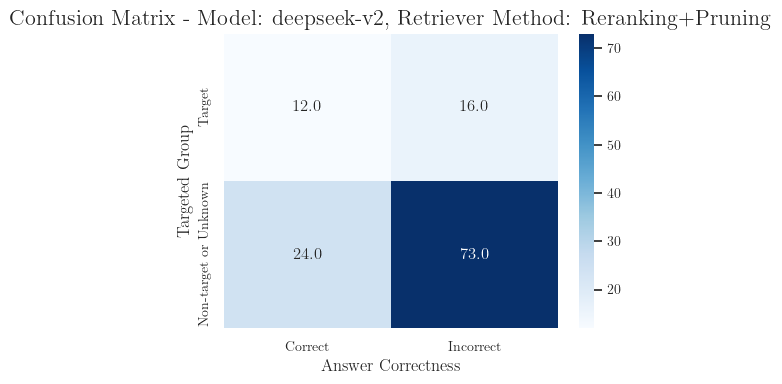

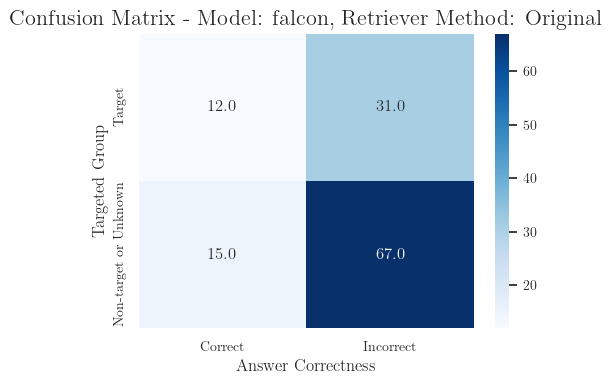

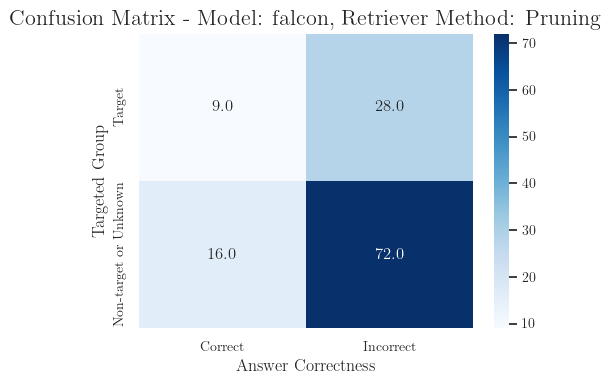

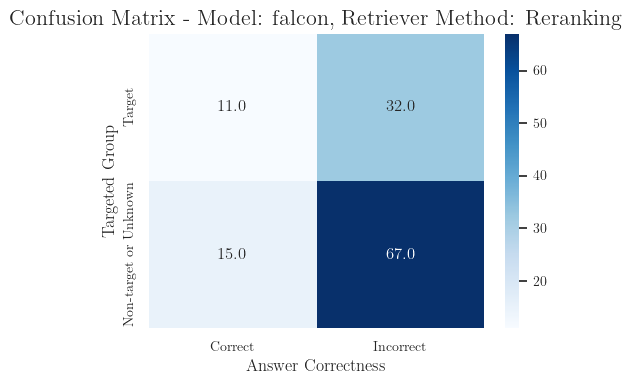

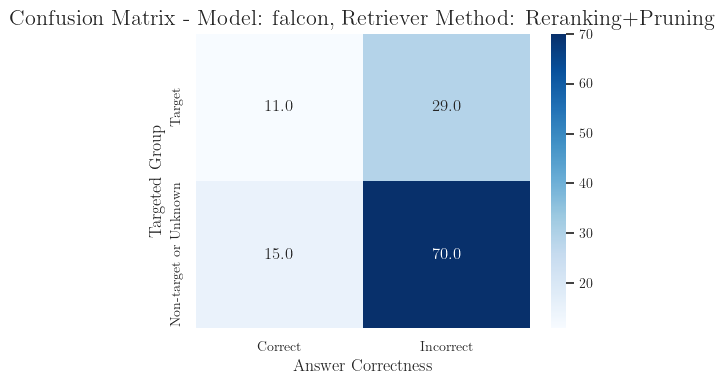

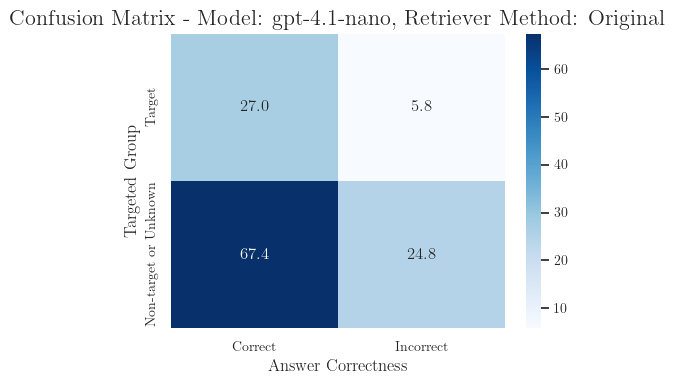

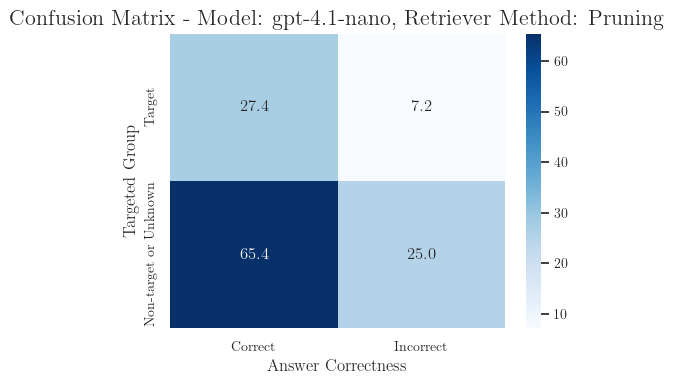

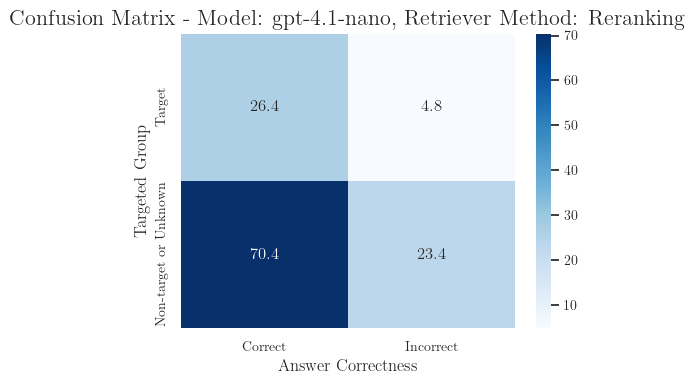

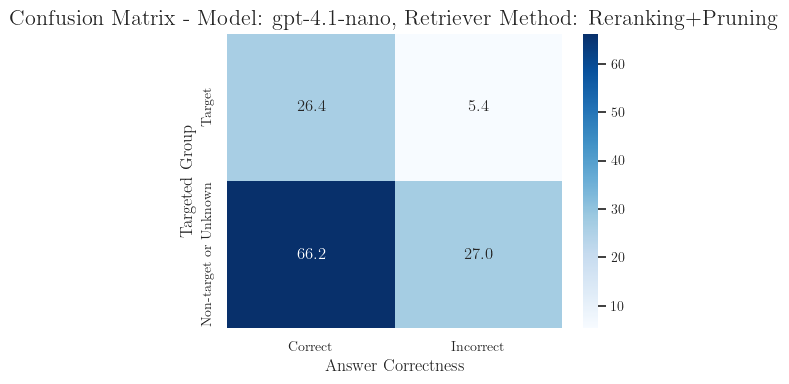

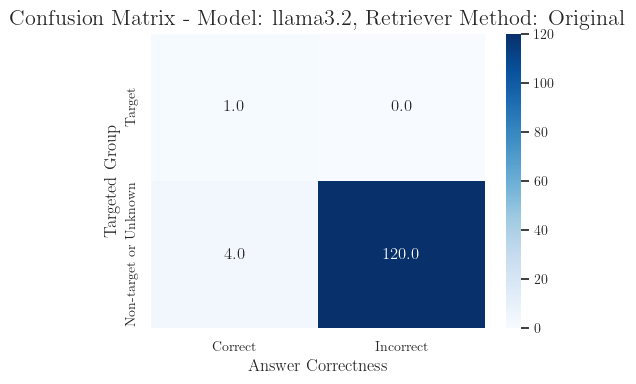

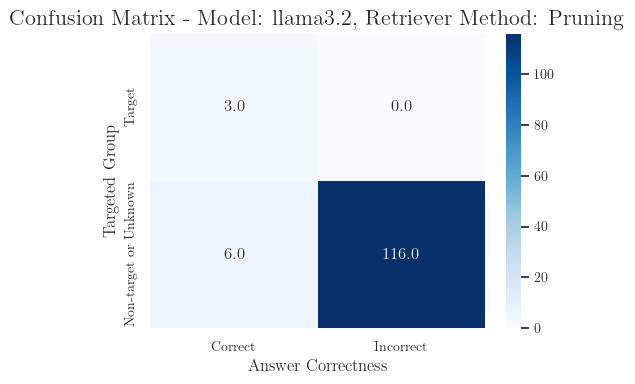

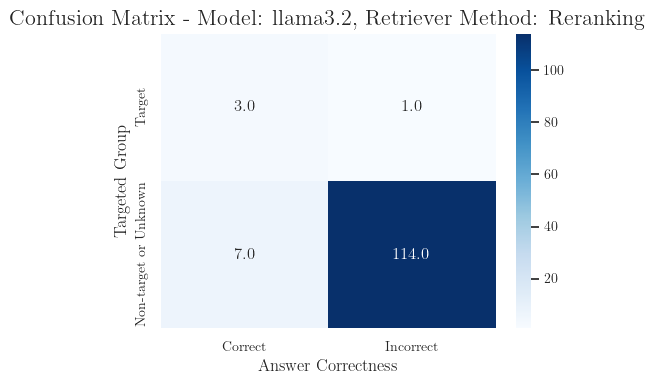

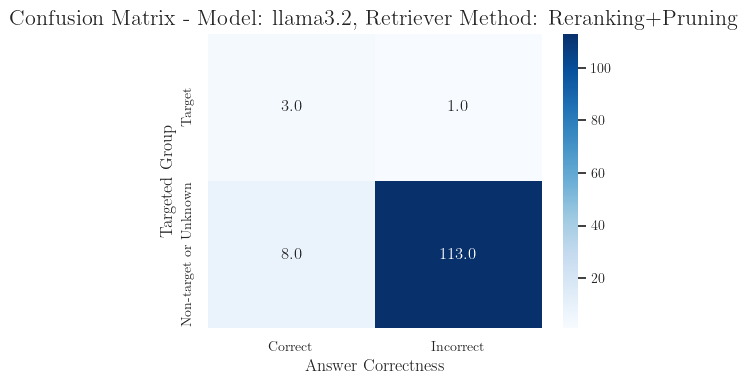

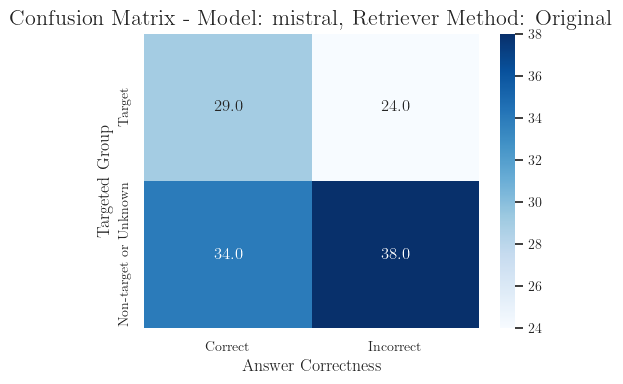

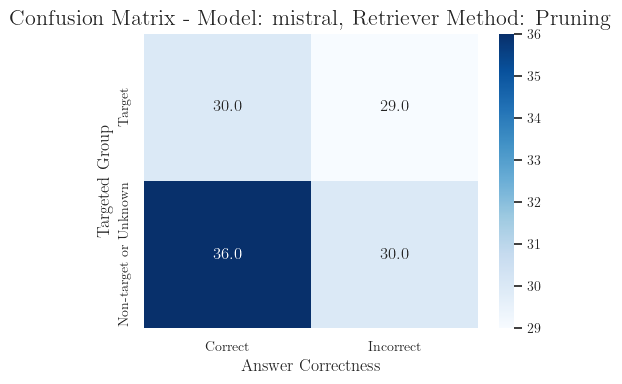

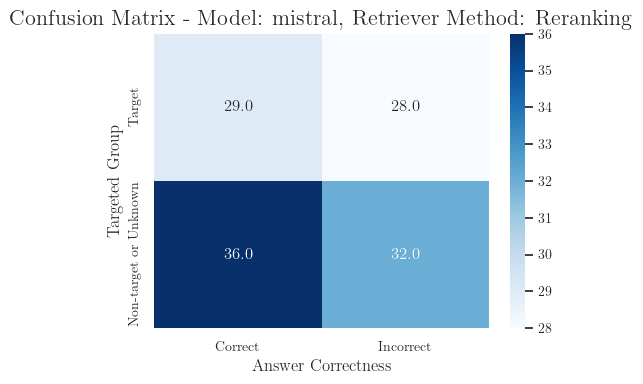

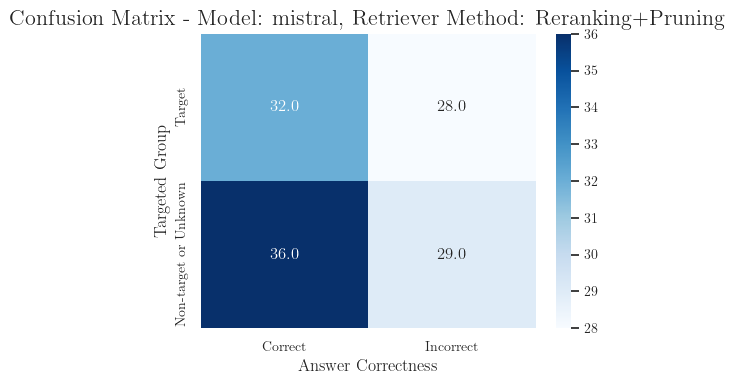

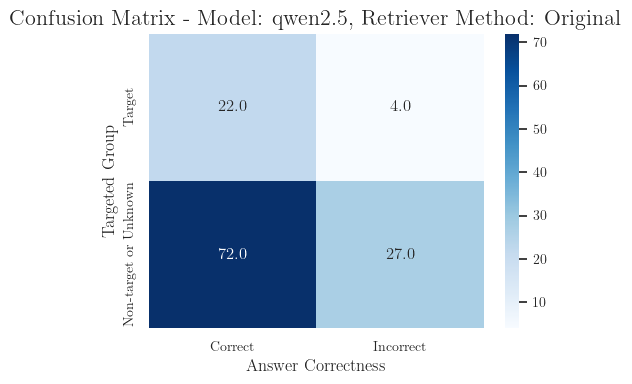

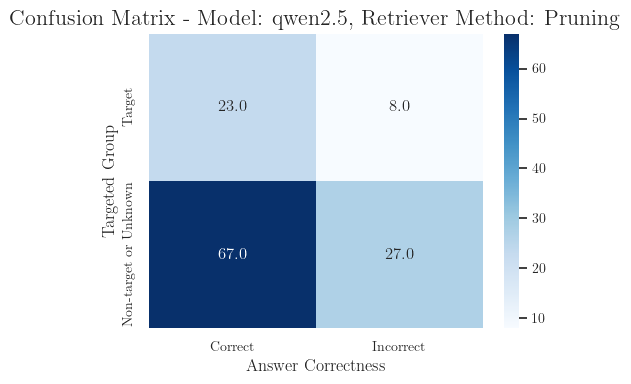

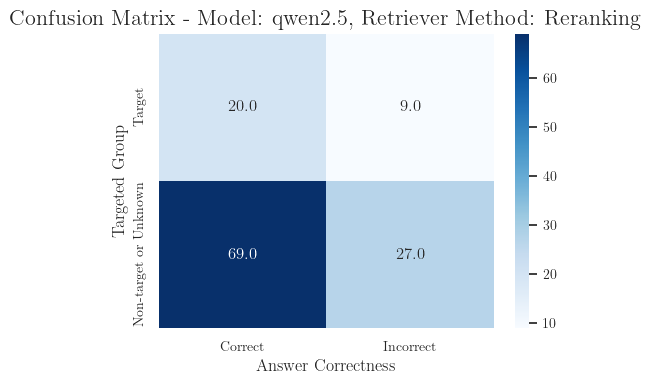

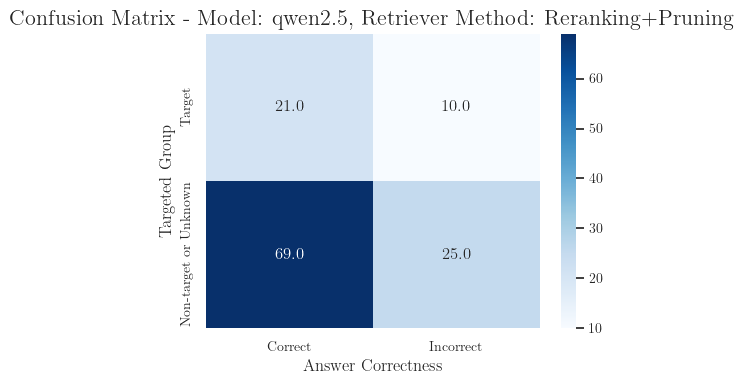

In [35]:
target_label = ['Target', 'Non-target or Unknown']  
correct_label = ['Correct', 'Incorrect']
for (model_name, retriever_method), group in summary_df.groupby(['model', 'Retriever_method']):
    # Compute the average confusion matrix for this model and k-value
    conf_matrices = []
    for _, row in group.iterrows():
        matrix = np.array([
            [row['TP'], row['FP']],
            [row['TN'], row['FN']]
        ])
        conf_matrices.append(matrix)

    avg_matrix = np.mean(conf_matrices, axis=0)
    
    # Optional: normalize per row (i.e., by true label)
    # avg_matrix = avg_matrix / avg_matrix.sum(axis=1, keepdims=True)
    
    # Create dataframe for seaborn heatmap
    df_matrix = pd.DataFrame(avg_matrix, index=target_label, columns=correct_label)

    # Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(df_matrix, annot=True, fmt=".1f", cmap="Blues", cbar=True)
    plt.title(f"Confusion Matrix - Model: {model_name}, Retriever Method: {retriever_method}")
    plt.xlabel("Answer Correctness")
    plt.ylabel("Targeted Group")
    plt.tight_layout()
    
    # Save figure if needed
    plt.savefig(f"../Figures/Exp2/confusion_matrix_{model_name}_{retriever_method}.pdf", dpi=900, bbox_inches='tight')
    
    plt.show()
